## ELEC5307-2021-S2: Project 1 report

### Name (SID): Hangyu Chen (490075948)

Please follow the instructions carefully:
- This project is based on Cifar-10 dataset. The basic loading operations are added already. Please do not use other dataset.
- Remove the corresponding `e.g.` and fill in all the blanks in this file, including some codes in Part 1, your choices for Part 2, your task for Part 3, and the analyses for your choices, specification of your computer, etc.
- Please do not change the format of this report.
- In your analyses, you can add math functions and graphs.
- Please make clear comments and references for any codes written by yourself or copied from other sources.

### Part 0: Prepare for Colab

The default colab uses CPU, you can add GPU resources in Runtime->Change runtime type->dropdown, select GPU->save

**Note: the following code is written for cpu, you need to allocate data and network to GPU on your own if you want to utilize GPU devices.**

### Part 1: Baseline model
You need to run this model successfully to get the marks. You should finish the codes that are used to split the training dataset into training set (45000 images) and validation set (5000 images) and draw the loss curve for training loss and validation loss. 

### 1.1 prepare data

In [ ]:
# useful packages
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader

In [ ]:
print(torch.cuda.is_available()) # check if cuda is avaliable so that we could use GPU

True


In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='/tmp/CIFAR10', train=True,
                                        download=True, transform=transform)
trainset = [item for item in trainset]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/tmp/CIFAR10', train=False,
                                       download=True, transform=transform)
testset = [item for item in testset]
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /tmp/CIFAR10/cifar-10-python.tar.gz to /tmp/CIFAR10
Files already downloaded and verified


### 1.2 split the training data into training and validation
In most of the cases, you are given the test set, so you need to prepare some validation data to evaluate your model during training stage. You need to make a validation dataset that contains 5000 training images, and the rest 45000 images are used as the new training set.

In [ ]:
# Your split codes here.
# You need to random select the 5000 validation images 

from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(trainset, test_size=0.1, random_state=10)
print(len(train_set)) # print the size of training set
print(len(val_set)) # print the size of validation set
print(len(testset)) # print the size of testing set
# when batch is 4
trainloader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                          shuffle=False, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=4,
                                          shuffle=False, num_workers=2)
# when batch is 2
trainloader2 = torch.utils.data.DataLoader(train_set, batch_size=2,
                                          shuffle=False, num_workers=2)
valloader2 = torch.utils.data.DataLoader(val_set, batch_size=2,
                                          shuffle=False, num_workers=2)
# when batch is 8
trainloader8 = torch.utils.data.DataLoader(train_set, batch_size=8,
                                          shuffle=False, num_workers=2)
valloader8 = torch.utils.data.DataLoader(val_set, batch_size=8,
                                          shuffle=False, num_workers=2)
# besides, you can also make modifications for faster training 
# by selecting a subset of the original dataset.

45000
5000
10000


### 1.3 Define a Baseline Convolution Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input channel = 3, output channel = 6, kernal size = 5*5
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2) # kernal size = 2*2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


# net = Net()
net = Net().cuda() # load the network on the GPU

### 1.4 Define a Loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### 1.5 Train the network

In [ ]:
def testset_precision(net, testset): # This function is used for calculate the accuracy for the testset
    dl = DataLoader(testset, batch_size = 128) # load test set
    total_count = 0  # total numbers of test set
    total_correct = 0 # total correct predictions of test set
    for data in dl:  # iterate test set
        inputs = data[0].cuda()  # input data, such as images, etc
        targets = data[1].cuda()   # ground truth labels
        outputs = net(inputs)    # get the outputs from network
        predicted_labels = outputs.argmax(dim=1)  # obtain the class with highest score as prediction
        comparison = predicted_labels == targets  # get a [True, False,...] matrix. True means correct prediction
        total_count += predicted_labels.size(0)   # accumulate the test number
        total_correct += comparison.sum()      # accumulate the number of correct predictions
        
    return int(total_correct) / int(total_count)

In [ ]:
# In this part, we train the network using batch size = 4
train_loss = []
train_acc = []
val_loss = []
val_acc = []
for epoch in range(4):  # loop over the dataset multiple times
    val_running_loss = 0.0
    for i, data in enumerate(valloader, 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available(): # load into GPU
          inputs,labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if torch.cuda.is_available():
          loss = loss.cpu()

        # print statistics
        val_running_loss += loss.item()
        # 5000/4 = 1250 batches
        # 1250/250 = 5 times (we could record the loss and accuracy 5 times with same interval = 250 in validation set)
        if i % 250 == 249:    # print every 250 mini-batches
            print('[%d, %5d] val_loss: %.3f' %
                  (epoch + 1, i + 1, val_running_loss / 250))
            print(f'validation set accuracy: {testset_precision(net, val_set)}')
            val_loss.append(val_running_loss / 250)
            val_acc.append(testset_precision(net,val_set))
            val_running_loss = 0.0
            
    train_running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
          inputs,labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if torch.cuda.is_available():
          loss = loss.cpu()

        # print statistics
        train_running_loss += loss.item()
        # 45000/4 = 11250 batches
        # 11250/2000 = 5.6 = 5 times (we could record the loss and accuracy 5 times with same interval = 2000 in training set)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] train_loss: %.3f' %
                  (epoch + 1, i + 1, train_running_loss / 2000))
            print(f'validation set accuracy: {testset_precision(net, train_set)}')
            train_loss.append(train_running_loss / 2000)
            train_acc.append(testset_precision(net,train_set))
            train_running_loss = 0.0
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,   250] val_loss: 2.305
validation set accuracy: 0.103
[1,   500] val_loss: 2.304
validation set accuracy: 0.1026
[1,   750] val_loss: 2.303
validation set accuracy: 0.1064
[1,  1000] val_loss: 2.302
validation set accuracy: 0.1242
[1,  1250] val_loss: 2.299
validation set accuracy: 0.1782
[1,  2000] train_loss: 2.198
validation set accuracy: 0.24084444444444444
[1,  4000] train_loss: 1.995
validation set accuracy: 0.29562222222222223
[1,  6000] train_loss: 1.799
validation set accuracy: 0.3918888888888889
[1,  8000] train_loss: 1.717
validation set accuracy: 0.3782
[1, 10000] train_loss: 1.643
validation set accuracy: 0.40473333333333333
[2,   250] val_loss: 1.520
validation set accuracy: 0.4518
[2,   500] val_loss: 1.564
validation set accuracy: 0.4606
[2,   750] val_loss: 1.570
validation set accuracy: 0.4612
[2,  1000] val_loss: 1.602
validation set accuracy: 0.4508
[2,  1250] val_loss: 1.507
validation set accuracy: 0.4898
[2,  2000] train_loss: 1.542
validation set accuracy: 0

### 1.6 visualize the loss and accuracy
Using the loss of both training data and validation data to evaluate the model. You may need to change some of the codes in 1.5 in order to save the loss into different lists.

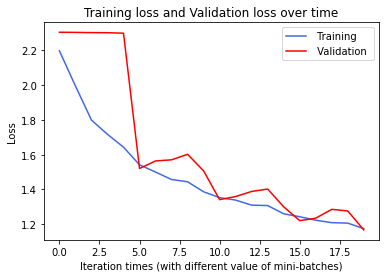

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show the loss
plt.figure()
plt.title('Training loss and Validation loss over time')
plt.plot(train_loss,'-',color = 'royalblue')
plt.plot(val_loss,'-',color = 'red')
plt.legend([' Training ',' Validation '])
plt.xlabel('Iteration times (with different value of mini-batches)')
plt.ylabel('Loss')
plt.show()


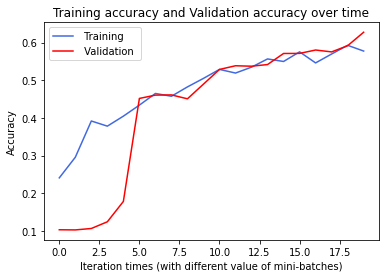

In [ ]:
# functions to show the loss
plt.figure()
plt.title('Training accuracy and Validation accuracy over time')
plt.plot(train_acc,'-',color = 'royalblue')
plt.plot(val_acc,'-',color = 'red')
plt.legend([' Training ',' Validation '])
plt.xlabel('Iteration times (with different value of mini-batches)')
plt.ylabel('Accuracy')
plt.show()

### 1.7 Eval the trained network

In [ ]:
def eval_net(net, testloader):
    net = net.eval()
    if torch.cuda.is_available():
          net = net.cuda()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if torch.cuda.is_available():
                images,lables = images.cuda(), labels.cuda()
            outputs = net(images)
            if torch.cuda.is_available():
                outputs = outputs.cpu()
                labels = labels.cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

eval_net(net, testloader)

Accuracy of the network on the 10000 test images: 53 %


### Part 2: Hyperparameters Selection
Following the instruction file, you need to make choices for each hyperparameters:

1. Batch size: 8
2. Base learning rate: 0.001
3. Number of epochs: 11

**Question**: Why do you make such choices? Use some figures, math equations, codes and printout to make analysis.

**Ans:**
We use three sections of code below. In the code, we firstly select a certain batch size, which is 2, 4 or 8. Then after selecting a certain batch size, we train the network for 6 times with different learning rate. We choose the epoch as 16 so that we could also see the training result with differnt epochs at the same time. Then we plot those diagrams and find the best result which 1) The test accuracy is relatively largest 2) The training loss is relatively minimum 3) The time needed is relatively small.

In this case, we choose three best results with different batch size:

1) batch size = 4, learning rate = 0.0001, epoch = 16; It has test accuracy = 0.58 and train loss = 1.1

2) batch size = 2, learning rate = 0.0001, epoch = 16; It has test accuracy = 0.60 and train loss = 1.0

3) batch size = 8, learning rate = 0.001, epoch = 11; It has test accuracy = 0.60 and train loss = 0.8

Comparing with the three best results above, I finally choose the third one, which has relativly large accuracy and small loss.


In [ ]:
# Your codes here. 
# Please do not define the networks again, just make changes to the training procedure, i.e. in the loop, please go through all the potential choices.
# train_loss = []
# train_acc = []
# val_loss = []
# val_acc = []


def mytrain(train_loss, test_acc, val_loss, val_acc, learning_rate): # This function is used to train the model with batch size = 4 only
  for n in range (len(learning_rate)):
    net = Net().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate[n], momentum=0.9)
    my_train_loss = []
    my_test_acc = []
    my_val_loss = []
    my_val_acc = []
    for epoch in range(16):  # loop over the dataset multiple times
      val_running_loss = 0.0
      for i, data in enumerate(valloader, 0):
          # get the inputs
          inputs, labels = data
          if torch.cuda.is_available():
            inputs,labels = inputs.cuda(), labels.cuda()
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          if torch.cuda.is_available():
            loss = loss.cpu()

          # print statistics
          val_running_loss += loss.item()
      print('The val_loss of the %d epoch is: %.3f' %
                    (epoch + 1, val_running_loss / len(valloader)))
      a = testset_precision(net, val_set)
      print(f'validation set accuracy is: {a}')
      my_val_loss.append(val_running_loss / len(valloader))
      my_val_acc.append(a)
          

      train_running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs
          inputs, labels = data
          if torch.cuda.is_available():
            inputs,labels = inputs.cuda(), labels.cuda()
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          if torch.cuda.is_available():
            loss = loss.cpu()

          # print statistics
          train_running_loss += loss.item()
      print('The train_loss of the %d epoch is: %.3f' %
                    (epoch + 1, train_running_loss / len(trainloader)))
      b = testset_precision(net, testset)
      print(f'test set accuracy is: {b}')
      my_train_loss.append(train_running_loss / len(trainloader))
      my_test_acc.append(b)
      train_running_loss = 0.0

    # add the value into lists after one epoch
    test_acc.append(my_test_acc)
    val_acc.append(my_val_acc)
    val_loss.append(my_val_loss)
    train_loss.append(my_train_loss)
    print('Finished Training for learning rate = %0.5f \n' %(learning_rate[n]))

### **When the batch size is 4:**

In [ ]:
learning_rate = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001] # we have 6 options for learning rate
# learning_rate = [0.005,0.001]
train_loss = []
test_acc = []
val_loss = []
val_acc = []
mytrain(train_loss, test_acc, val_loss, val_acc, learning_rate)

The val_loss of the 1 epoch is: 2.296
validation set accuracy is: 0.1016
The train_loss of the 1 epoch is: 1.927
test set accuracy is: 0.3315
The val_loss of the 2 epoch is: 1.725
validation set accuracy is: 0.4452
The train_loss of the 2 epoch is: 1.707
test set accuracy is: 0.3222
The val_loss of the 3 epoch is: 1.702
validation set accuracy is: 0.4368
The train_loss of the 3 epoch is: 1.678
test set accuracy is: 0.3652
The val_loss of the 4 epoch is: 1.676
validation set accuracy is: 0.4688
The train_loss of the 4 epoch is: 1.680
test set accuracy is: 0.3697
The val_loss of the 5 epoch is: 1.649
validation set accuracy is: 0.469
The train_loss of the 5 epoch is: 1.665
test set accuracy is: 0.3725
The val_loss of the 6 epoch is: 1.687
validation set accuracy is: 0.446
The train_loss of the 6 epoch is: 1.665
test set accuracy is: 0.3374
The val_loss of the 7 epoch is: 1.684
validation set accuracy is: 0.4732
The train_loss of the 7 epoch is: 1.681
test set accuracy is: 0.3739
The val_

The length of the train_loss is 6
The length of the first item in train_loss is 16


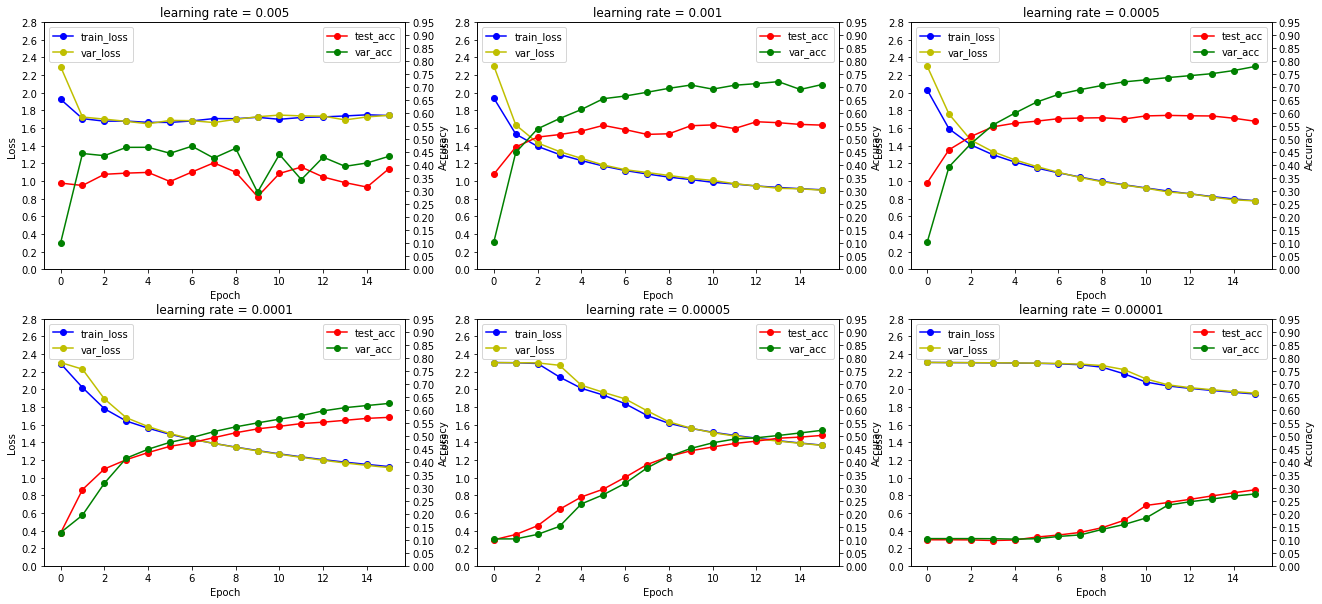

In [ ]:
print('The length of the train_loss is %d' %len(train_loss))
print('The length of the first item in train_loss is %d' %len(train_loss[0]))
plt.figure
plt.figure(figsize=(22,10))
plt.subplot(2,3,1)

plt.title('learning rate = 0.005')
plt.plot(np.arange(16),train_loss[0][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss[0][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc[0][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc[0][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,2)
plt.title('learning rate = 0.001')
plt.plot(np.arange(16),train_loss[1][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss[1][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc[1][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc[1][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,3)
plt.title('learning rate = 0.0005')
plt.plot(np.arange(16),train_loss[2][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss[2][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc[2][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc[2][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,4)
plt.title('learning rate = 0.0001')
plt.plot(np.arange(16),train_loss[3][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss[3][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc[3][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc[3][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,5)
plt.title('learning rate = 0.00005')
plt.plot(np.arange(16),train_loss[4][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss[4][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc[4][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc[4][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,6)
plt.title('learning rate = 0.00001')
plt.plot(np.arange(16),train_loss[5][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss[5][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc[5][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc[5][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

In [ ]:
def mytrain2(train_loss, test_acc, val_loss, val_acc, learning_rate): # This function is used to train the network with dataset batch size = 2
  for n in range (len(learning_rate)):
    net = Net().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate[n], momentum=0.9)
    my_train_loss = []
    my_test_acc = []
    my_val_loss = []
    my_val_acc = []
    for epoch in range(16):  # loop over the dataset multiple times
      val_running_loss = 0.0
      for i, data in enumerate(valloader2, 0):
          # get the inputs
          inputs, labels = data
          if torch.cuda.is_available():
            inputs,labels = inputs.cuda(), labels.cuda()
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          if torch.cuda.is_available():
            loss = loss.cpu()

          # print statistics
          val_running_loss += loss.item()
      print('The val_loss of the %d epoch is: %.3f' %
                    (epoch + 1, val_running_loss / len(valloader2)))
      a = testset_precision(net, val_set)
      print(f'validation set accuracy is: {a}')
      my_val_loss.append(val_running_loss / len(valloader2))
      my_val_acc.append(a)
          

      train_running_loss = 0.0
      for i, data in enumerate(trainloader2, 0):
          # get the inputs
          inputs, labels = data
          if torch.cuda.is_available():
            inputs,labels = inputs.cuda(), labels.cuda()
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          if torch.cuda.is_available():
            loss = loss.cpu()

          # print statistics
          train_running_loss += loss.item()
      print('The train_loss of the %d epoch is: %.3f' %
                    (epoch + 1, train_running_loss / len(trainloader2)))
      b = testset_precision(net, testset)
      print(f'test set accuracy is: {b}')
      my_train_loss.append(train_running_loss / len(trainloader2))
      my_test_acc.append(b)
      train_running_loss = 0.0

    test_acc.append(my_test_acc)
    val_acc.append(my_val_acc)
    val_loss.append(my_val_loss)
    train_loss.append(my_train_loss)
    print('Finished Training for learning rate = %0.5f \n' %(learning_rate[n]))

### **When the batch size is 2:**

In [ ]:
learning_rate = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
train_loss2 = []
test_acc2 = []
val_loss2 = []
val_acc2 = []
mytrain2(train_loss2, test_acc2, val_loss2, val_acc2, learning_rate)

The val_loss of the 1 epoch is: 2.248
validation set accuracy is: 0.1934
The train_loss of the 1 epoch is: 2.033
test set accuracy is: 0.2766
The val_loss of the 2 epoch is: 2.002
validation set accuracy is: 0.2626
The train_loss of the 2 epoch is: 2.021
test set accuracy is: 0.2475
The val_loss of the 3 epoch is: 2.039
validation set accuracy is: 0.2732
The train_loss of the 3 epoch is: 2.035
test set accuracy is: 0.2673
The val_loss of the 4 epoch is: 2.235
validation set accuracy is: 0.1
The train_loss of the 4 epoch is: 2.137
test set accuracy is: 0.23
The val_loss of the 5 epoch is: 2.043
validation set accuracy is: 0.2662
The train_loss of the 5 epoch is: 2.024
test set accuracy is: 0.2626
The val_loss of the 6 epoch is: 2.022
validation set accuracy is: 0.283
The train_loss of the 6 epoch is: 2.001
test set accuracy is: 0.2383
The val_loss of the 7 epoch is: 1.989
validation set accuracy is: 0.2806
The train_loss of the 7 epoch is: 1.986
test set accuracy is: 0.2199
The val_loss

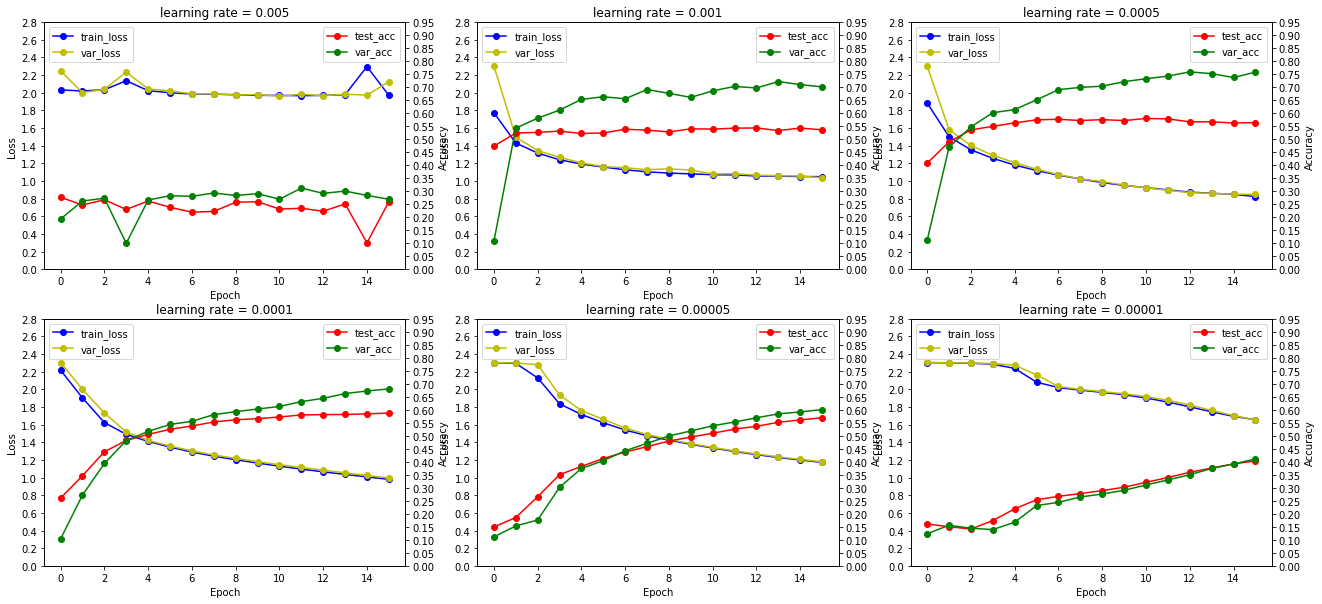

In [ ]:
plt.figure
plt.figure(figsize=(22,10))
plt.subplot(2,3,1)

plt.title('learning rate = 0.005')
plt.plot(np.arange(16),train_loss2[0][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss2[0][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc2[0][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc2[0][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,2)
plt.title('learning rate = 0.001')
plt.plot(np.arange(16),train_loss2[1][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss2[1][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc2[1][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc2[1][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,3)
plt.title('learning rate = 0.0005')
plt.plot(np.arange(16),train_loss2[2][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss2[2][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc2[2][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc2[2][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,4)
plt.title('learning rate = 0.0001')
plt.plot(np.arange(16),train_loss2[3][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss2[3][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc2[3][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc2[3][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,5)
plt.title('learning rate = 0.00005')
plt.plot(np.arange(16),train_loss2[4][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss2[4][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc2[4][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc2[4][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,6)
plt.title('learning rate = 0.00001')
plt.plot(np.arange(16),train_loss2[5][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss2[5][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc2[5][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc2[5][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

In [ ]:
def mytrain8(train_loss, test_acc, val_loss, val_acc, learning_rate): # This function is used for training the network with datset batch size = 8
  for n in range (len(learning_rate)):
    net = Net().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate[n], momentum=0.9)
    my_train_loss = []
    my_test_acc = []
    my_val_loss = []
    my_val_acc = []
    for epoch in range(16):  # loop over the dataset multiple times
      val_running_loss = 0.0
      for i, data in enumerate(valloader8, 0):
          # get the inputs
          inputs, labels = data
          if torch.cuda.is_available():
            inputs,labels = inputs.cuda(), labels.cuda()
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          if torch.cuda.is_available():
            loss = loss.cpu()

          # print statistics
          val_running_loss += loss.item()
      print('The val_loss of the %d epoch is: %.3f' %
                    (epoch + 1, val_running_loss / len(valloader8)))
      a = testset_precision(net, val_set)
      print(f'validation set accuracy is: {a}')
      my_val_loss.append(val_running_loss / len(valloader8))
      my_val_acc.append(a)
          

      train_running_loss = 0.0
      for i, data in enumerate(trainloader8, 0):
          # get the inputs
          inputs, labels = data
          if torch.cuda.is_available():
            inputs,labels = inputs.cuda(), labels.cuda()
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          if torch.cuda.is_available():
            loss = loss.cpu()

          # print statistics
          train_running_loss += loss.item()
      print('The train_loss of the %d epoch is: %.3f' %
                    (epoch + 1, train_running_loss / len(trainloader8)))
      b = testset_precision(net, testset)
      print(f'test set accuracy is: {b}')
      my_train_loss.append(train_running_loss / len(trainloader8))
      my_test_acc.append(b)
      train_running_loss = 0.0

    test_acc.append(my_test_acc)
    val_acc.append(my_val_acc)
    val_loss.append(my_val_loss)
    train_loss.append(my_train_loss)
    print('Finished Training for learning rate = %0.5f \n' %(learning_rate[n]))

### **When the batch size is 8:**

In [ ]:
learning_rate = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
train_loss8 = []
test_acc8 = []
val_loss8 = []
val_acc8 = []
mytrain8(train_loss8, test_acc8, val_loss8, val_acc8, learning_rate)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


The val_loss of the 1 epoch is: 2.252
validation set accuracy is: 0.1802
The train_loss of the 1 epoch is: 1.767
test set accuracy is: 0.442
The val_loss of the 2 epoch is: 1.540
validation set accuracy is: 0.5132
The train_loss of the 2 epoch is: 1.487
test set accuracy is: 0.4899
The val_loss of the 3 epoch is: 1.402
validation set accuracy is: 0.5658
The train_loss of the 3 epoch is: 1.381
test set accuracy is: 0.4955
The val_loss of the 4 epoch is: 1.323
validation set accuracy is: 0.5508
The train_loss of the 4 epoch is: 1.325
test set accuracy is: 0.498
The val_loss of the 5 epoch is: 1.293
validation set accuracy is: 0.6338
The train_loss of the 5 epoch is: 1.283
test set accuracy is: 0.4987
The val_loss of the 6 epoch is: 1.243
validation set accuracy is: 0.6066
The train_loss of the 6 epoch is: 1.262
test set accuracy is: 0.5051
The val_loss of the 7 epoch is: 1.234
validation set accuracy is: 0.6014
The train_loss of the 7 epoch is: 1.246
test set accuracy is: 0.515
The val_l

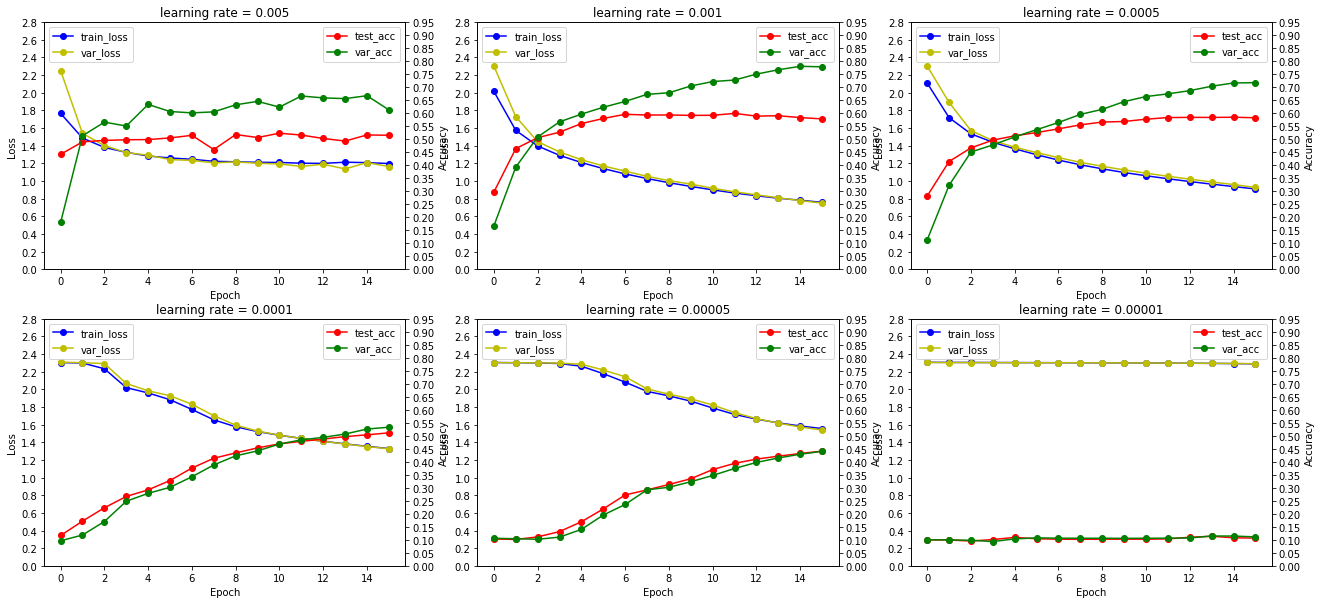

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure
plt.figure(figsize=(22,10))
plt.subplot(2,3,1)

plt.title('learning rate = 0.005')
plt.plot(np.arange(16),train_loss8[0][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss8[0][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc8[0][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc8[0][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,2)
plt.title('learning rate = 0.001')
plt.plot(np.arange(16),train_loss8[1][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss8[1][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc8[1][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc8[1][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,3)
plt.title('learning rate = 0.0005')
plt.plot(np.arange(16),train_loss8[2][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss8[2][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc8[2][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc8[2][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,4)
plt.title('learning rate = 0.0001')
plt.plot(np.arange(16),train_loss8[3][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss8[3][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc8[3][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc8[3][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,5)
plt.title('learning rate = 0.00005')
plt.plot(np.arange(16),train_loss8[4][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss8[4][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc8[4][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc8[4][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

plt.subplot(2,3,6)
plt.title('learning rate = 0.00001')
plt.plot(np.arange(16),train_loss8[5][0:16],color = 'b',marker = 'o')
plt.plot(np.arange(16),val_loss8[5][0:16],color = 'y',marker = 'o')
plt.yticks(np.arange(0,3,0.2))
plt.legend(['train_loss','var_loss'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.twinx()
plt.plot(np.arange(16),test_acc8[5][0:16],color = 'r',marker = 'o')
plt.plot(np.arange(16),val_acc8[5][0:16],color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.05))
plt.ylabel('Accuracy')
plt.legend(['test_acc','var_acc'],loc = 'upper right')

**your analysis comes here:**
-----
To begin with, the reason why I choose batch size = 8, learning rate = 0.001 and epoch = 11 as the best result has shown at the beginning of this section. I considered by 1) The test accuracy is relatively largest 2) The training loss is relatively minimum 3) The time needed is relatively small.

**1. What are the choice that could be empirically ignored without doing any experiments? Were you correct after you conduct the experiment?**

**Ans:** 1) For the batch size, as we need to divide the datasets into several batches and the number of training examples in a single batch is called batch size (SAGAR SHARMA, 2017). In this case, we could ignore the batch size = 2. It is because we have 45000 images in the training set and 5000 images in the validation set, which means the datasets are quite large.  However, if the batch size is 2, it means we need 45000/2 = 22500 iterations for each epoch and this will take a long time in total.

2) For the learning rate, as we need to do the Gradient Descent so that we could find the minima of a curve (e.g. loss function) in order to get the best results(SAGAR SHARMA, 2017). If we choose a very small lerning rate, it means we need such a long time to find the minima point. However, if the learning rate is large, we might miss the minima point during the Gradient Descent. In this case, we could ignore the learning rate = 0.00001 because it is too small.

3) For the epoch, an epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE (SAGAR SHARMA, 2017). If the number of epoch is small, the result will be underfitting, but if it is too large, the result will be overfitting. As we know that there are only 10 labels in cifar-10 dataset, so 15 or 16 maybe too large to cause the overfitting, and 1 or 2 maybe too small so that it is underfitting.

**2. How many epochs are passed when the network is converged?**

**Ans:** We could say the network is converged if it achieves a state during training in which loss settles to within an error range around the final value, which means the network will not be improved if we continue training (Daniel & David, 2019). So based on the loss and accuracy curve, we could find that the curves normally are converged when the epoch is larger than 8, but it will also depend on the learning rate we choose. So in the network I choose which has the best result, the network may considered as converged after epoch = 13, which is because the loss curve is becoming flatten after this point.

**3. Why too large and too small learning rates are not good choices?**

**Ans:** The learning rate is used for gradient descent when we are training our model. However, if the value is too small, it means there will be many updates before we reach the minima point. In this case, it will take a long time to get the result. And if the value is too large, it will cause drastic updates, which will finally lead to divergent behaviours so that we could miss the minimum point (Jeremy Jordan, 2018) and the network cannot be converged.

**4. What are the the specification of the computer you are using?**

**Ans:** I used T4 GPU by using Colab Pro. And I simply put all my datasets and network on to GPU in order to train the model and make the process quickly.

**5. How long do you run an epoch? Did you use samples of the original dataset to speed up your progress?**

**Ans:** As for each training, I used 16 epochs and to show the loss and accuracy for each dataset. So the time needed for running an epoch = total time/16 = 68 seconds on average. And I used validation dataset which is separated from original training dataset to show if the training result become worse after a certain number of epoch so that it could help me deal with the overfitting problem. So that I could simply stop training if it become worse and change the parameters in time, which could save the time.

**6. Are there any overfitting problems?**

**Ans:** Overfitting usually occurs when model trains for too long on sample data or when the model is too complex, which means it can start to learn the “noise” (IBM,2021). We could determine if it happens by looking through the loss and accuracy curves. As we have divided part of the training dataset to validation set, so if the train loss value is decreasing but the validation loss value is flattening or increasing, it means overfitting occurs. We could deal with the overfitting by early-stopping or change the parameters of our network. 

**7. Is there any Limitation/Drawback?**

Ans: Yes, as we have 45000 images in training datset and 5000 images in validation dataset. If we use a small batch size (e.g. 2, 4, 8) such as what we have done previously, it means we can just deal with small number of images at the same time, which will take us such as long time to finish the whole training process.

### Part 3: More options

Please indicate the **three** tasks you are assigned here:

1) Transformation: Normalize + Resize

2) Structure: add Dropout Layers

3) Training procedure: optimizer: SGD settings

For your new baseline and the test for different options, you need to write them in **ONE** single `.py` file. You can debug here, but do **NOT** include your codes in the submitted ipynb file. Your codes for this part will be put in the **project1.py** file.

**Question**: how do you define your new baseline and why? Please highlight the differences between your new baseline and the previous baseline.

##### your analysis comes here:
-----
To begin with, I change the batch size of the datasets from 8 (which is the best result I got in part2) to 256. With this method, it means we could deal with more images at the same time, which could increase the speed of computing.

The main differences between the new baseline and previous baseline network are: I changed the kernal size from 5 to 3; change the channel numbers for each convolution layers; change the value of learning rate; Add pooling layers.

1) Kernal size

Kernal is what we used to extract the features from images. With a samller odd number filter (kernal), all the previouse layer pixels would be symmetrically around the output pixel, otherwise we need to consider the distortions across layers with an even sized kernal (Sabyasachi, 2018). Besides, with a small size of kernal, we could have less generalization and less ambiguity during training. In this case, I reduced the kernal size from 5 to 3 in order to have a better result.

2) Channel numbers

In the first convolutional layer, the input channel should be 3 because the input images are RGB images. And when I increased the output channel from 6 to 16, it represents there are more feature maps. Larger output channel numbers means we could learn more useful features about the input data.

3) Value of learning rate

We have already found in part2 that a larger learning rate could increase the training speed although it could not be too large in order to prevent the drastic updates which make the network hard to converge. In this case, I increase the learning rate from 0.001 (best result in part2) to 0.01 so that it could increase the training speed.

4) Pooling layers

In order to have a better training result, one thing we could do is making the network deeper. In this case, I also add 3 MaxPooling layers and each of them is after a convolutional layer. The useage of pooling layer is that it could summarises the features present generated by convolutional layer so that it could reduce the dimensions of the feature maps and the number of parameters to learn (as we increased the number of output channels in convolution layers), which could save time needed for computation.

I used 2*2 kernal size in max pooling layer. It means for each 2 by 2 square region in the images, we considered the maximum value in this region as its new feature.




_____

**Question**: how did you test the three tasks and what did you learn? Please use some figures, math equations and output from your codes to make analysis. 

##### your analysis comes here:
-----
1) Normalize + Resize:

We know that, the images in Cifar-10 datasets have size 32*32 and RGB value from 0 to 255. In this case, we firstly use .Tosensor() to change the intensity value of image in range (0-255) to (0-1). And after we apply Normalize function, this value could be a float number in the range of (-1,1). The formula we calculate the final value after nomalizing is:

image = (image-mean)/std

In this case, if we use `transform.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))`, the minimum value in range (0,1) will become (0-0.5)/0.5 = -1; The maximum value 1 will become (1-0.5)/0.5 = 1

The reason we want to normalize is that neural networks prefer floating point values within a small range, which helps in making training a lot faster (Avinash, 2018).

And as we are required to do the resize for input images, `transforms.Resize(45)` function is applied to change the size of Cifar-10 images from 32 * 32 to 45 * 45


2) add Dropout layers:

Dropout layer is what we used to reduce overfitting and improve generalization error in neural networks (Jason Brownlee, 2018). It randomly dropping out nodes during training so that it is considered as a very computationally cheap method.

I added two Dropout layers with same dropping possibilities and each one of them is after a fully connected layer.

Dropping means there are differnt chances of setting inputs to zero after we set the value of possibility.
Then, I compared three different results by using Dropout layers with possibility equals to 0.2, 0.3 and 0.4.


The results are quite similar, I chose dropout = 0.3 because the validation accuracy could reach to 90% and test accuracy could reach to 70% finally. But when it is 0.4, the validation accuracy could only reach to 85% and test accuracy reach to 65%. Also for possibility = 0.2, it will take longer time and reach almost the same result as when possibility = 0.3.

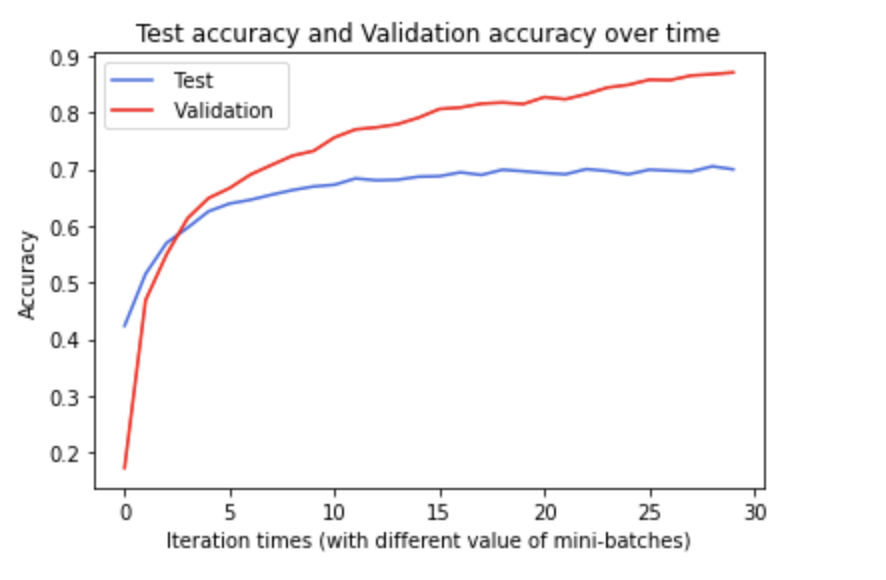
_____

3) SGD settings

SGD with momentum is method which helps accelerate gradients vectors in the right directions, thus leading to faster converging (Vitaly, 2017). In this part, I changed the momentum and weight decay of the SGD optimizer.

With Stochastic Gradient Descent we don’t compute the exact derivate of our loss function, which means we are not always going in the optimal direction. In this case, a proper momentum will help accelerate gradients in the right direction (Vitaly, 2017).

Firstly I kept the weight decay as 0, then change the value of momentum.
People usually choose momentum 0.5, 0.9, 0.95.

After I compared these three results, if 0.5 is chosen as the momentum, we could only get 60% accuracy for the testset after 30 epoch. And if 0.99 is chosen as momentum, the network could be considered as converged and tend to overfitting after 20 epoch and could only get 65% accuracy for the testset as shown below.

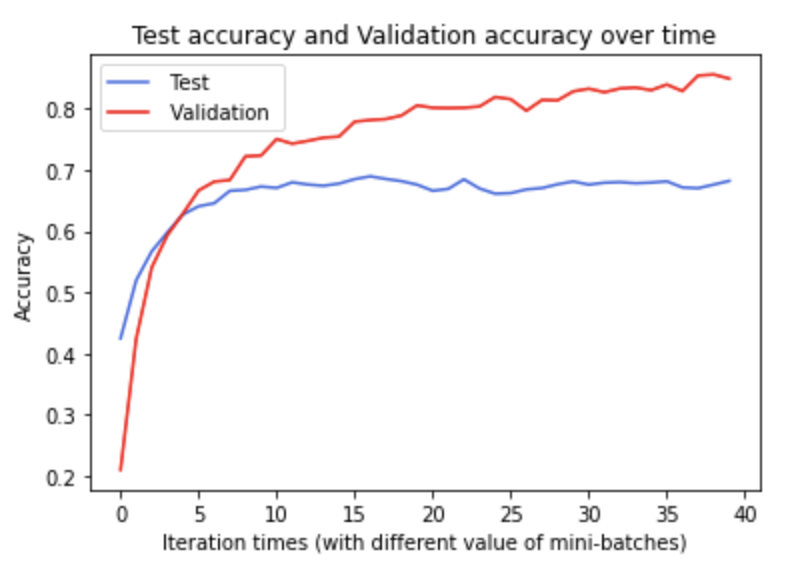


So I choose 0.95 finally and it only need 21 epoch to reach an accuracy 70% for testset.
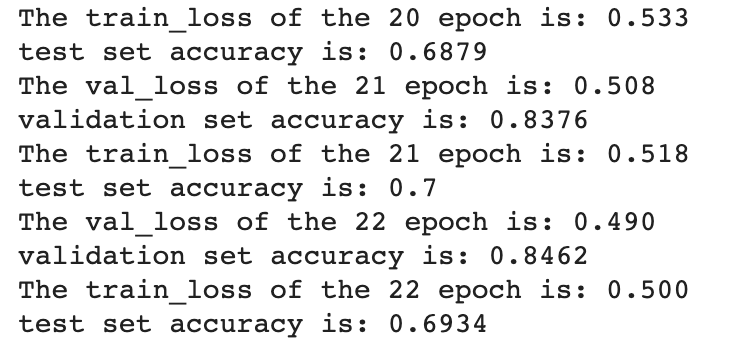

And for the weight decay, it is a regularization technique by adding a small penalty to the loss function. And with this method, we could prevent overfitting and avoid exploding gradient (Sophia,2020).
We usually choose 1e-4 and 1e-3 as our weight decay, so I compared these two results with other parameters maintain the same.
And the final result for testing accuracy is 74% if choose 1e-3 as the weight decay compared to 1e-4 which has accuracy 72%.

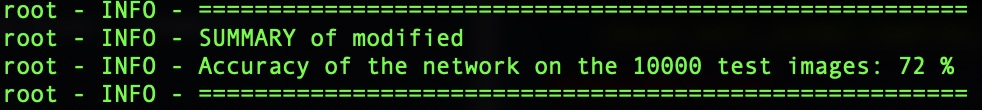

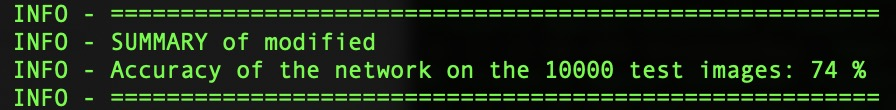



### Reference
1. SAGAR SHARMA (Sep, 2017), *Epoch vs Batch Size vs Iterations*, Retired from:
https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

2. Daniel Kobran and David Banys (2019), *Convergence*, Retired from: https://docs.paperspace.com/machine-learning/wiki/convergence

3. Jeremy Jordan (Mar, 2018), *Setting the learning rate of your neural network*, Retired from: https://www.jeremyjordan.me/nn-learning-rate/

4. Sabyasachi Sahoo (Aug, 2018), Deciding optimal kernel size for CNN, Retired from: https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363

5. Avinash (Nov,2018), What is Transform and Transform Normalize? (Lesson 4 — Neural Networks in PyTorch), Retired from:
https://medium.com/@ml_kid/what-is-transform-and-transform-normalize-lesson-4-neural-networks-in-pytorch-ca97842336bd

6. Jason Brownlee (Dec, 2018), A Gentle Introduction to Dropout for Regularizing Deep Neural Networks, Retired from:
https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

7. Vitaly Bushaev (Dec,2017), *Stochastic Gradient Descent with momentum*, Retired from: https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d

8. Sophia Chen (Sep, 2020), *Deep learning basics — weight decay*, Retired from:
https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9


9. The code for calculating the testset precision (`def testset_precision(net, testset)`) is copied from the code used in the tutorial. The detail could be found in tutorial5 .ipynb file.

10. The code for plotting the accuracy and lost with different datasets could be found in GeeksforGeeks website:
https://www.geeksforgeeks.org/matplotlib-pyplot-twinx-in-python/



### Specs:
e.g. Your cpu version or GPU version, the memory size of your computer. Your pytorch software versions.